In [2]:
import numpy as np
import math
from scipy import ndimage as ndi
import matplotlib.pyplot as plt
from skimage.feature import peak_local_max
from skimage import data, img_as_float
import time
import glob,os
import cv2
import scipy.io as sio
from scipy import signal
import csv

(-0.5, 511.5, 511.5, -0.5)

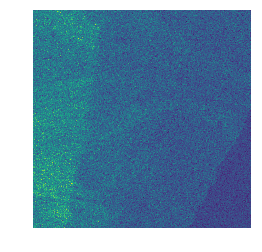

In [6]:
path = '/srv/home/chenyu/DEbackup/110719/S1/'
path_HAADF = path + 'HAADF_Preview_512_512_1_38_07_PM.csv'
with open(path_HAADF) as csvfile:
    file=csv.reader(open(path_HAADF,'r'))
    n=[]
    for row in file:
        n.append(row)

HAADFarray = np.transpose(np.asarray(n))
HAADFarray = np.squeeze(HAADFarray)
HAADFarray = HAADFarray.astype(np.float)
HAADFarray = np.reshape(HAADFarray,(512,512))
plt.imshow(HAADFarray)
plt.axis('off')

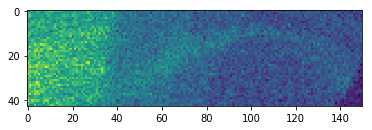

In [7]:
rx = 150
ry = 43
path = '/srv/home/chenyu/DEbackup/110719/S1/'
path_HAADF = path + 'HAADF_Preview_150_43_1_47_31_PM.csv'
with open(path_HAADF) as csvfile:
    file=csv.reader(open(path_HAADF,'r'))
    n=[]
    for row in file:
        n.append(row)

HAADFarray = np.transpose(np.asarray(n))
HAADFarray = np.squeeze(HAADFarray)
HAADFarray = HAADFarray.astype(np.float)
HAADFarray = np.reshape(HAADFarray,(ry,rx))
plt.imshow(HAADFarray)

In [8]:
# Align diffraction patterns inside this region using blank scan
dataset = np.zeros((ry,rx,300,300))
PACBED = np.zeros((1024,1024))
for irow in range(ry):
    for icol in range(rx):
        nSample = irow * rx + icol + 1;
        Sample = np.load(path+'npy/S1_'+format(nSample,'05')+'.npy')
        Sample[Sample<0] = 0
        PACBED = PACBED + Sample
        resized = cv2.resize(Sample, (300,300), interpolation = cv2.INTER_AREA)
        dataset[irow,icol,:,:] = np.sqrt(resized)

In [9]:
%matplotlib notebook
import hyperspy.api as hs
s = hs.signals.Signal2D(data=dataset)

<IPython.core.display.Javascript object>


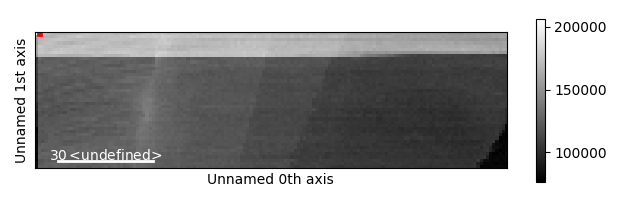

<IPython.core.display.Javascript object>


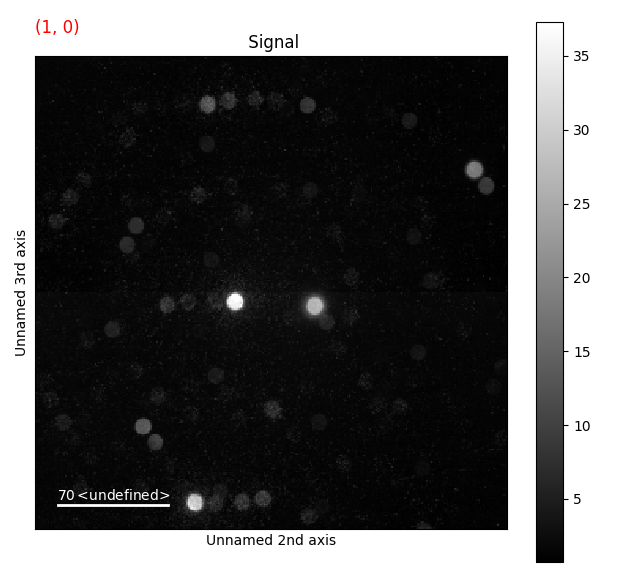

In [142]:
s.plot()

In [9]:
from scipy import ndimage as ndi
from skimage.feature import peak_local_max
from skimage import data, img_as_float
from scipy.ndimage import gaussian_filter

In [10]:
# Test on single frame
irow = 0
icol = 141

if icol==1:
    ref = center_pos[irow-1,icol,:]  # for col=1, take ref point from row on top
else:
    ref = center_pos[irow,icol-1,:]  # for col!=1, take ref point from left side
nSample = irow * rx + icol + 1;
Sample = np.load(path+'npy/S1_'+format(nSample,'05')+'.npy')
Sample[Sample<0] = 0
resized = cv2.resize(Sample, (300,300), interpolation = cv2.INTER_AREA)
im = np.sqrt(resized)
im = gaussian_filter(im, sigma=3) # Apply Gaussian filter to transfer disk into peak
image_max = ndi.maximum_filter(im, size=25, mode='constant')
coordinates = peak_local_max(im, min_distance=10)
int_list = im[coordinates[:,0],coordinates[:,1]]  # extract intensity for all the peaks
inds = int_list.argsort()[::-1]
coordinates_sorted = coordinates[inds,:]
coordinates_sorted = coordinates_sorted[0:4,:]  # only focus on the first five high intensity disks
dist = np.sqrt(np.sum((coordinates_sorted-ref)**2,axis=1))
coordinates_sorted = coordinates_sorted[dist<50]
center_pos[irow,icol,:] = coordinates_sorted[0,:]

fig = plt.figure(figsize=(10,5))
fig.add_subplot(121)
plt.imshow(im)
plt.plot(coordinates[:,1],coordinates[:,0],'r.')
int_list = im[coordinates[:,0],coordinates[:,1]]  # extract intensity for all the peaks
                                                  # Center beam should be among the ones with high intensities

fig.add_subplot(122)
plt.imshow(np.sqrt(resized))
plt.plot(center_pos[irow,icol,1],center_pos[irow,icol,0],'r.')

NameError: name 'center_pos' is not defined

In [11]:
# Register with center beam, beam stopper was not used, no reference scan necessary

center_pos = np.zeros((ry,rx,2)) # in order of row, col
center_pos[0,1,:] = [155,127]  # insert ref from row=0, col=1, manually picked to make sure zero beam is used
                               # sometimes strong diffracted beam under 2beam condition can be as strong as zero beam
for irow in range(ry):
    for icol in range(1,rx):
        if irow==0 and icol==1:
#             print(irow,icol,ref)
            continue  # skip the original point
        if icol==1:
            ref = center_pos[irow-1,icol,:]  # for col=1, take ref point from row on top
        else:
            ref = center_pos[irow,icol-1,:]  # for col!=1, take ref point from left side
#         print(irow,icol,ref)
        nSample = irow * rx + icol + 1;
        Sample = np.load(path+'npy/S1_'+format(nSample,'05')+'.npy')
        Sample[Sample<0] = 0
        resized = cv2.resize(Sample, (300,300), interpolation = cv2.INTER_AREA)
        im = np.sqrt(resized)
        im = gaussian_filter(im, sigma=3) # Apply Gaussian filter to transfer disk into peak
        image_max = ndi.maximum_filter(im, size=25, mode='constant')
        coordinates = peak_local_max(im, min_distance=10)
        int_list = im[coordinates[:,0],coordinates[:,1]]  # extract intensity for all the peaks
        inds = int_list.argsort()[::-1]
        coordinates_sorted = coordinates[inds,:]  # sort disk coordinates according to descending intensity
        coordinates_sorted = coordinates_sorted[0:4,:]  # only focus on the first five high intensity disks
        dist = np.sqrt(np.sum((coordinates_sorted-ref)**2,axis=1))
        coordinates_sorted = coordinates_sorted[dist<50]  # use disk that is within 50px to the center disk before this frame
        center_pos[irow,icol,:] = coordinates_sorted[0,:]

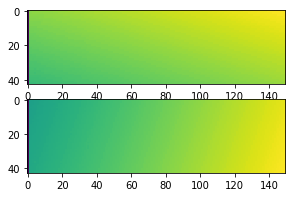

In [12]:
# Plot center point positions to make sure the transition is smooth 
fig = plt.figure(figsize=(6,3))
fig.add_subplot(211)
plt.imshow(center_pos[:,:,0])
fig.add_subplot(212)
plt.imshow(center_pos[:,:,1])

In [13]:
# Run registration with detected center beam positions
dataset_registered = np.zeros((ry,rx,300,300))
num_rows, num_cols = dataset_registered.shape[-2:]
for irow in range(ry):
    for icol in range(1,rx):
        nSample = irow * rx + icol + 1;
        Sample = np.load(path+'npy/S1_'+format(nSample,'05')+'.npy')
        Sample[Sample<0] = 0
        resized = cv2.resize(Sample, (300,300), interpolation = cv2.INTER_AREA)
        im = np.sqrt(resized)
        
        x = center_pos[irow,icol,1] - center_pos[0,1,1]
        y = center_pos[irow,icol,0] - center_pos[0,1,0]
        translation_matrix = np.float32([[1,0,-x],[0,1,-y]])
        dataset_registered[irow,icol,:,:] = cv2.warpAffine(im, translation_matrix, (num_cols, num_rows))

In [15]:
np.save('/srv/home/chenyu/DEbackup/110719/S1/RegisteredSeries.npy',dataset_registered)

<IPython.core.display.Javascript object>


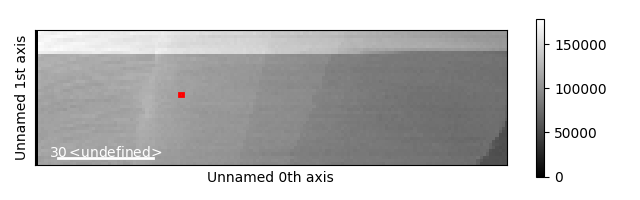

<IPython.core.display.Javascript object>


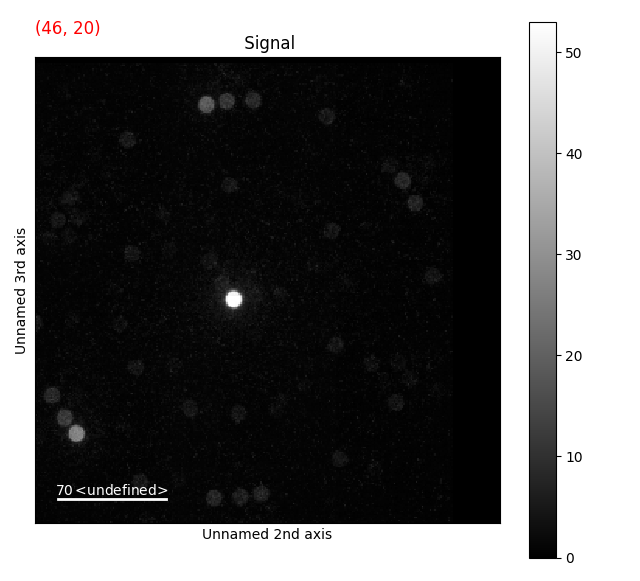

In [210]:
%matplotlib notebook
import hyperspy.api as hs
s = hs.signals.Signal2D(data=dataset_registered)
s.plot()

150 43


/srv/home/chenyu/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:47: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.
/srv/home/chenyu/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:48: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.
/srv/home/chenyu/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:49: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.
/srv/home/chenyu/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.
/srv/home/chenyu/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:51: DeprecationWarni

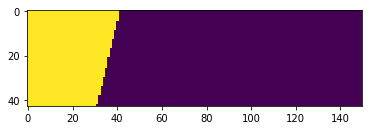

In [53]:
import scipy.misc
# Generate separte PACBED on each layer
# Three straight lines separate region with 4/3/2/1 layers:
# 4/3: y = -4.2x + 172.2
# 3/2: y = -3.5x + 269.5
# 2/1: y = -2.3x + 233.3
# Generate and save real space BF image
RealSpace = np.sum(np.sum(dataset_registered,axis=3),axis=2)
plt.imshow(np.sqrt(RealSpace))
# scipy.misc.imsave('/srv/home/chenyu/DEbackup/110719/S1/RealSpace.jpg',RealSpace)

# PACBED from the whole field of view
PACBED_registered = np.sum(np.sum(dataset_registered,axis=0),axis=0)
# plt.imshow(np.sqrt(PACBED_registered))
# plt.axis('off')

# generate meshgrid for x and y
ky, kx = RealSpace.shape[0:2]
print(kx, ky)
kx = np.linspace(0,kx-1,kx)
ky = np.linspace(0,ky-1,ky)
grid_x, grid_y = np.meshgrid(kx,ky)


# 1 layer
PACBED_1 = np.zeros(PACBED_registered.shape[0:2])
PACBED_2 = np.zeros(PACBED_registered.shape[0:2])
PACBED_3 = np.zeros(PACBED_registered.shape[0:2])
PACBED_4 = np.zeros(PACBED_registered.shape[0:2])
mask_1 = grid_y > -2.3 * grid_x + 233.3
mask_2 = (grid_y > -3.5 * grid_x + 269.5) & (~mask_1)
mask_3 = (grid_y > -4.2 * grid_x + 172.2) & (~mask_1) & (~mask_2)
mask_4 = (~mask_3) & (~mask_2) & (~mask_1)
plt.imshow(mask_4)
for irow in range(RealSpace.shape[0]):
    for icol in range(RealSpace.shape[1]):
        if mask_1[irow,icol]==1:
            PACBED_1 = PACBED_1 + dataset_registered[irow,icol,:,:]
        elif mask_2[irow,icol] == 1:
            PACBED_2 = PACBED_2 + dataset_registered[irow,icol,:,:]
        elif mask_3[irow,icol] == 1:
            PACBED_3 = PACBED_3 + dataset_registered[irow,icol,:,:]
        elif mask_4[irow,icol] == 1:
            PACBED_4 = PACBED_4 + dataset_registered[irow,icol,:,:]
            
# save all the PACBEDs
scipy.misc.imsave('/srv/home/chenyu/DEbackup/110719/S1/RealSpace.jpg',RealSpace)
scipy.misc.imsave('/srv/home/chenyu/DEbackup/110719/S1/PACBED_whole.jpg',PACBED_registered)
scipy.misc.imsave('/srv/home/chenyu/DEbackup/110719/S1/PACBED_1layer.jpg',PACBED_1)
scipy.misc.imsave('/srv/home/chenyu/DEbackup/110719/S1/PACBED_2layer.jpg',PACBED_2)
scipy.misc.imsave('/srv/home/chenyu/DEbackup/110719/S1/PACBED_3layer.jpg',PACBED_3)
scipy.misc.imsave('/srv/home/chenyu/DEbackup/110719/S1/PACBED_4layer.jpg',PACBED_4)

scipy.misc.imsave('/srv/home/chenyu/DEbackup/110719/S1/RealSpace.jpg',RealSpace)
scipy.misc.imsave('/srv/home/chenyu/DEbackup/110719/S1/PACBED_whole_sqrt.jpg',np.sqrt(PACBED_registered))
scipy.misc.imsave('/srv/home/chenyu/DEbackup/110719/S1/PACBED_1layer_sqrt.jpg',np.sqrt(PACBED_1))
scipy.misc.imsave('/srv/home/chenyu/DEbackup/110719/S1/PACBED_2layer_sqrt.jpg',np.sqrt(PACBED_2))
scipy.misc.imsave('/srv/home/chenyu/DEbackup/110719/S1/PACBED_3layer_sqrt.jpg',np.sqrt(PACBED_3))
scipy.misc.imsave('/srv/home/chenyu/DEbackup/110719/S1/PACBED_4layer_sqart.jpg',np.sqrt(PACBED_4))

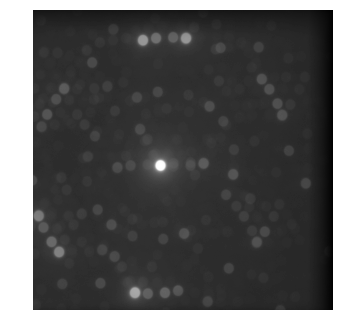

In [74]:
fig = plt.figure(frameon=False)
fig.set_size_inches(300/72,300/72)
ax = plt.Axes(fig, [0., 0., 1., 1.])
ax.set_axis_off()
fig.add_axes(ax)
ax.imshow(np.sqrt(PACBED_4),cmap='gray')
fig.savefig(fname='/srv/home/chenyu/DEbackup/110719/S1/PACBED_4layers_sqrt.tif', dpi=72)

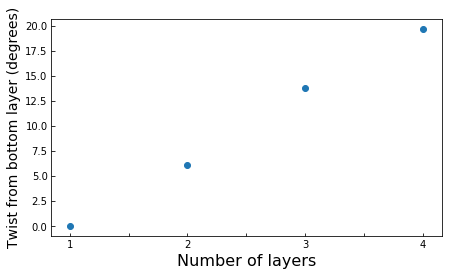

In [2]:
angle_list = [0,6.16,13.85,19.73]
layer_list = [1,2,3,4]

fig, ax = plt.subplots(figsize=(7,4))
fig.canvas.draw()
ax.scatter(layer_list,angle_list)
plt.ylabel('Twist from bottom layer (degrees)',fontsize=14)
plt.xlabel('Number of layers',fontsize=16)
labels = ['','1', '', '2', '', '3', '', '4', '', '', '']
# plt.grid('on')
ax.tick_params(direction='in')
# labels = [item.get_text() for item in ax.get_xticklabels()]
# print(labels)
# labels[1] = 'Testing'

ax.set_xticklabels(labels)

plt.show()

[19.94315217  6.19543478]
0.9918411494179207


/srv/home/chenyu/anaconda/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


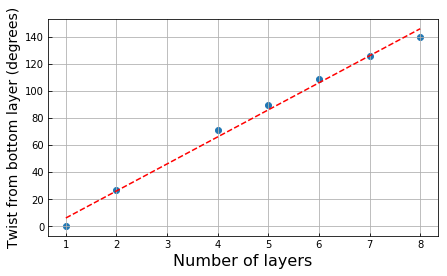

In [22]:
from sklearn.metrics import r2_score
angle_list = [152.12,124.96,81.15,62.21,43.24,26.57,12.70]
layer_list = [0,1,3,4,5,6,7]
z = np.polyfit(layer_list,152.12-np.asarray(angle_list), 1)
print(z)
print(r2_score(152.12-np.asarray(angle_list),np.asarray(layer_list)*z[0]+z[1]))

fig, ax = plt.subplots(figsize=(7,4))
fig.canvas.draw()
ax.scatter(layer_list,152.12-np.asarray(angle_list))
ax.plot(np.linspace(0,7,100),np.linspace(0,7,100)*z[0]+z[1],'--',c='r')
plt.ylabel('Twist from bottom layer (degrees)',fontsize=14)
plt.xlabel('Number of layers',fontsize=16)
labels = ['','1', '2', '3', '4', '5', '6','7','8']
plt.grid('on')
ax.tick_params(direction='in')
# labels = [item.get_text() for item in ax.get_xticklabels()]
# print(labels)
# labels[1] = 'Testing'

ax.set_xticklabels(labels)

plt.show()

[19.28828829  7.77477477]
0.9902459109710386


/srv/home/chenyu/anaconda/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


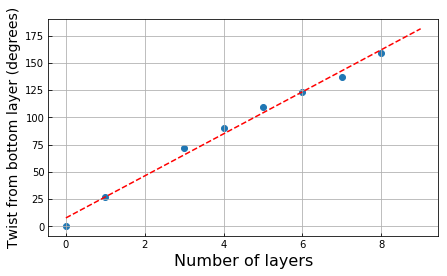

In [11]:
from sklearn.metrics import r2_score
angle_list = [0,27,72,90,110,123,137,159]
layer_list = [0,1,3,4,5,6,7,8]
z = np.polyfit(layer_list,np.asarray(angle_list), 1)
print(z)
print(r2_score(np.asarray(angle_list),np.asarray(layer_list)*z[0]+z[1]))

fig, ax = plt.subplots(figsize=(7,4))
fig.canvas.draw()
ax.scatter(layer_list,np.asarray(angle_list))
ax.plot(np.linspace(0,9,100),np.linspace(0,9,100)*z[0]+z[1],'--',c='r')
plt.ylabel('Twist from bottom layer (degrees)',fontsize=14)
plt.xlabel('Number of layers',fontsize=16)
# labels = ['','1', '2', '3', '4', '5', '6','7','8']
plt.grid('on')
ax.tick_params(direction='in')
# labels = [item.get_text() for item in ax.get_xticklabels()]
# print(labels)
# labels[1] = 'Testing'

# ax.set_xticklabels(labels)

plt.show()